<a href="https://colab.research.google.com/github/Vngel0/Python_UC/blob/main/Clase_5_Arboles_y_Bosques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árboles de decisión

Los árboles de decisión son algoritmos versátiles y potentes. 
- Se pueden utilizar para problemas de clasificación, regresión u otros
- No requiere escalar las variables de ingreso
- Alta interpretabilidad
- Forman la base del algoritmo Random Forest que veremos hoy

Realizaremos los dos tipos de árboles conocidos como `DecisionTreeRegressor` y `DecisionTreeClassifier`.

In [1]:
#librerias base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#librerias de modelacion y metricas
from sklearn.model_selection import GridSearchCV #haremos grillas de hiperparametros con validacion cruzada
from sklearn.tree import DecisionTreeRegressor # tree REGRESOR
from sklearn.tree import DecisionTreeClassifier, plot_tree# tree CLASSIFIER
from sklearn.model_selection import train_test_split, cross_val_score #modelacion y evaluacion de CV
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score #metricas de evaluacion

#librerias 
import warnings
warnings.filterwarnings("ignore")

Trabajaremos con un set de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos. Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable `Sale_Price` (variable numérica).

In [3]:
df = pd.read_csv("https://storage.googleapis.com/diplomado-data-science-uc-python/python/06-Arboles-Bosques/data/ames_housing.csv", 
                 index_col=0)

In [4]:
df.head(2)

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,...,Electrical,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
1,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,Norm,OneFam,One_Story,Above_Average,Average,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112,Typical,Typical,CBlock,Typical,Good,Gd,BLQ,2,Unf,0,441,1080,GasA,Fair,...,SBrkr,1656,0,0,1656,1,0,1,0,3,1,Typical,7,Typ,2,Good,Attchd,Fin,2,528,Typical,Typical,Partial_Pavement,210,62,0,0,0,0,No_Pool,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
2,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,North_Ames,Feedr,Norm,OneFam,One_Story,Average,Above_Average,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,Typical,Typical,CBlock,Typical,Typical,No,Rec,6,LwQ,144,270,882,GasA,Typical,...,SBrkr,896,0,0,896,0,0,1,0,2,1,Typical,5,Typ,0,No_Fireplace,Attchd,Unf,1,730,Typical,Typical,Paved,140,0,0,0,120,0,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014


Luego realizaremos nuestro `Features Engineering`. Recordemos que debemos pasar nuestras variables categóricas a números y lo haremos con la técnica de one hot encoding que vimos la semana pasada. En estos casos recodificaremos con `k-1` atributos para cada variable, puesto que al recategorizar la ausencia de una variable se entiende como "variable de referencia", y por ello eliminaremos una de las categorias. Eliminar la categoría con mayor cantidad suele darle más estabilidad al modelo de machine learning (puede optimizar la convergencia). Sin embargo, para efectos prácticos eliminaremos simplemente la primera categoría.

Nota: No olvidemos que al crear una recategorización de la variable, debemos eliminar la variable original para evitar la multicolonealidad.

In [5]:
a=[]
for i,j in enumerate(df):
    if df[j].dtype=='object':
        a.append(j)
df2 = pd.get_dummies(df, columns=a, prefix=a,drop_first=True)

In [ ]:
df2.head(2)

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0


observemos que la primera cateogria (columna) ahora es MS_SubClass_ concatenado a las categorias de dicha variable:

In [6]:
df.MS_SubClass.value_counts()

One_Story_1946_and_Newer_All_Styles          1079
Two_Story_1946_and_Newer                      575
One_and_Half_Story_Finished_All_Ages          287
One_Story_PUD_1946_and_Newer                  192
One_Story_1945_and_Older                      139
Two_Story_PUD_1946_and_Newer                  129
Two_Story_1945_and_Older                      128
Split_or_Multilevel                           118
Duplex_All_Styles_and_Ages                    109
Two_Family_conversion_All_Styles_and_Ages      61
Split_Foyer                                    48
Two_and_Half_Story_All_Ages                    23
One_and_Half_Story_Unfinished_All_Ages         18
PUD_Multilevel_Split_Level_Foyer               17
One_Story_with_Finished_Attic_All_Ages          6
One_and_Half_Story_PUD_All_Ages                 1
Name: MS_SubClass, dtype: int64

In [7]:
df2.MS_SubClass_One_Story_1946_and_Newer_All_Styles

1       1
2       1
3       1
4       1
5       0
       ..
2926    0
2927    1
2928    0
2929    1
2930    0
Name: MS_SubClass_One_Story_1946_and_Newer_All_Styles, Length: 2930, dtype: uint8

y la variable, `df2.MS_SubClass_Duplex_All_Styles_and_Ages` no existe pues por abecedario es la primera por lo tanto se le hizo el drop

Luego calcularemos nuestro modelo de regresión y veremos sus métricas

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('Sale_Price',axis=1),
                                                    df2['Sale_Price'],test_size= .33 ,random_state= 65 )

In [9]:
dec_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [10]:
print( "Test MSE:" , mean_squared_error(y_test,dec_tree.predict(X_test)).round( 5 ))
print( "Test MAE:" , median_absolute_error(y_test,dec_tree.predict(X_test)).round( 5 ))
print( "Test R2:" , r2_score(y_test, dec_tree.predict(X_test)).round( 5 ))

Test MSE: 1558587890.7394
Test MAE: 16800.0
Test R2: 0.76641


Si bien nuestras métricas son aceptables, no estamos tomando en cuenta un elemento muy importante: el *principio de parsimonia*. Lo que se busca es obtener la mayor cantidad de información posible, con la menor cantidad de atributos posibles. Este "tira y afloja" se puede optimizar viendo que variables son las que realmente aportan información al modelo, y cuales no. Para eso calcularemos la `importancia relativa` de cada uno de nuestros atributos, y rescataremos los que más aportan información. Esto lo realizaremos con la función `.feature_importances_` de un modelo "fiteado":

In [11]:
importancia = dec_tree.feature_importances_ #nos da el valor proporcional de la importancia de cada columna
importancia_orden = np.argsort(importancia)[::-1] #nos permite obtener el indice al que pertenece cada feature
nombres = [df2.drop('Sale_Price',axis=1).columns[i] for i in importancia_orden] #rescatamos el nombre de las features 
                                                                                #ordenadas por importancia

In [12]:
aux = pd.DataFrame({'importancia':importancia[importancia_orden], 'atributo':nombres})
aux.head(10)

,importancia,atributo
0,0.360478,Garage_Cars
1,0.202857,Gr_Liv_Area
2,0.074713,Year_Built
3,0.056326,First_Flr_SF
4,0.048835,Exter_Qual_Typical
5,0.044582,Total_Bsmt_SF
6,0.025490,Second_Flr_SF
7,0.020966,Lot_Area
8,0.016171,Bsmt_Qual_Good
9,0.012703,Longitude


In [13]:
sum(aux.importancia[0:10])
#notemos que con las primeras 10 variables ya tenemos una alta variabilidad explicada por el modelo
#lo cual evidencia que no necesitamos los 307 atributos

0.863122109477038

In [14]:
top10= [df2.drop('Sale_Price',axis=1).columns[i] for i in  np.argsort(dec_tree.feature_importances_)[::-1]][0:10]

In [15]:
top10.append('Sale_Price') #le agregamos nuestro vector objetivo

In [16]:
# generamos un nuevo df que usaremos para entrenar
df_top10 = df2.filter(top10)

In [17]:
df_top10.head(2)

,Garage_Cars,Gr_Liv_Area,Year_Built,First_Flr_SF,Exter_Qual_Typical,Total_Bsmt_SF,Second_Flr_SF,Lot_Area,Bsmt_Qual_Good,Longitude,Sale_Price
1,2,1656,1960,1656,1,1080,0,31770,0,-93.619754,215000
2,1,896,1961,896,1,882,0,11622,0,-93.619756,105000


Ahora es un buen momento para volver a entrenar, pero realizaremos validación cruzada para una búsqueda de hiperparámetros óptimos. Para esto le entregamos posibles valores de hiperparametros como diccionario e iteramos el proceso

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_top10.drop('Sale_Price',axis=1),
                                                    df_top10['Sale_Price'],test_size= .33 ,random_state= 60 )

In [ ]:
%time
dec_tree_grid_cv = GridSearchCV(DecisionTreeRegressor(),
# evaluamos los siguientes escenarios
{
# con una profundidad de ramas hasta 32
'max_depth' : np.linspace( 1 , 32 , 32 ),

# evaluando todos los atributos en la matriz
'max_features' : list(range( 1 ,X_train.shape[ 1 ]))},
# Con 5 validaciones cruzadas
cv= 5 ,
# Ocupando todos los núcleos del computador
n_jobs= -1 ).fit(X_train, y_train)

Wall time: 0 ns


In [ ]:
print( "Test MSE:" , mean_squared_error(y_test,dec_tree_grid_cv.predict(X_test)).round( 5 ))
print( "Test MAE:" , median_absolute_error(y_test,dec_tree_grid_cv.predict(X_test)).round( 5 ))
print( "Test R2:" , r2_score(y_test, dec_tree_grid_cv.predict(X_test)).round( 5 ))

Test MSE: 1858605278.51428
Test MAE: 20338.71028
Test R2: 0.7211


Como podemos observar, las métricas son levemente peores, pero a costa de reducir 297 atributos, pues pasámos de 307 variables a 10.

También es posible saber cuales fueron los hiperparámetros leccionados con `modelo.best_params_`

In [ ]:
dec_tree_grid_cv.best_params_

{'max_depth': 5.0, 'max_features': 8}

Nota: a pesar de que le dimos 10 atributos al modelo, solo fueron necesarias 8.

A continuación veremos un `DecisionTreeClassifier`, cuya idea es la misma, pero ahora nos enfocaremos en un vector objetivo de clasificación. Para simplicidad utilizaremos los datos de prueba clásicos llamados *iris*. Este es un set con 4 atributos numericas y una quinta columna de categorías 1, 2 y 3 (las cuales son 'setosa', 'versicolor' y 'virginica')

In [18]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X = X[:, 2:] #solo nos quedaremos con 2 de las 4 columnas para hacerlo aún más simple, (la info del petalo)


y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

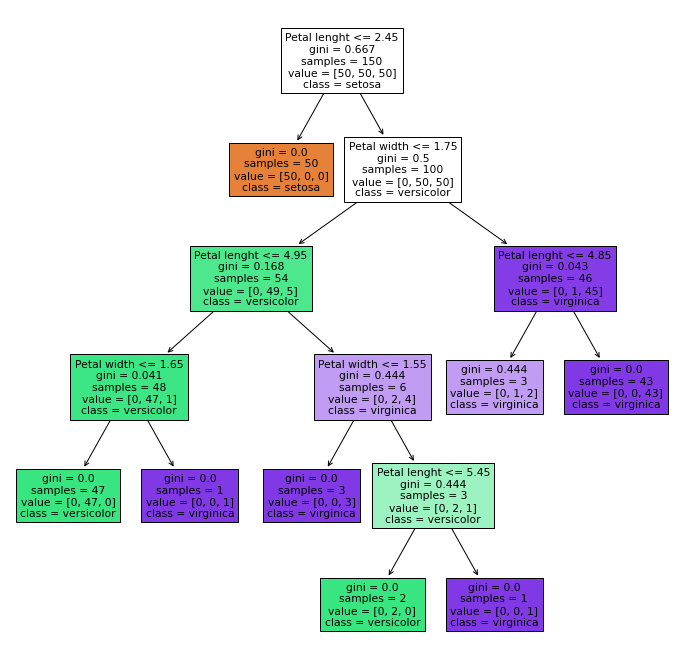

In [19]:
model = DecisionTreeClassifier().fit(X, y)

fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(model, 
          filled=True, 
          feature_names=['Petal lenght', 'Petal width'], 
          class_names=['setosa', 'versicolor', 'virginica']);

Como vimos anteriormente, podemos controlar el proceso de construcción de este arbol usando diferentes parámetros. 
- `max_depth`: Máximo numero de divisiones consecutivas que se pueden realizar
- `min_samples_split`: Número mínimo de samples en un nodo antes de dividirlo
- `min_samples_leaf`: Numero mínimo de samples en una nodo terminal
- `max_leaf_nodes`: Número máximo de nodos terminales.

Consideremos cómo afecta la estructura del arbol cada uno de estos parámetros y ayudemonos visualmente del gráfico

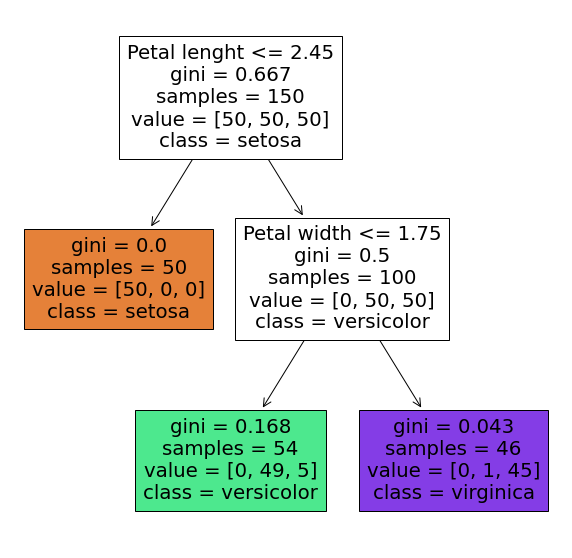

In [20]:
model = DecisionTreeClassifier(max_depth=2).fit(X, y)

fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(model, 
          filled=True, 
          feature_names=['Petal lenght', 'Petal width'], 
          class_names=['setosa', 'versicolor', 'virginica']);

## Predecir probabilidades

Supongamos que tenemos una flor cuyos pétalos tienen largo 3 cm y ancho 1 cm. Usando el modelo entrenado podemos predecir el tipo de flor que es usando

In [21]:
model.predict([[3, 1]])

array([1])

Pertenece a la clase 1, que es virgínica

Ahora que tenemos un entendimiento de los árboles, abordaremos el concepto de **Bagging**

Este método consiste en generar replicas del dataset de entrenamiento mediante la técnica de bootstrap, de esta forma podremos entrenar nuestro modelo con distintos dataset tomando como predicciones en ellos ya sea un método de votación (en el caso de clasificación) o un promedio (en caso de regresión) entre todos.

La formulación de este método permite claramente generarlo para cualquier modelo, pero el modelo donde más popular se ha hecho este método es utilizandolo sobre árboles de decisión, los que se conocen como Random Forest.

Comencemos haciendo bagging (BaggingRegressor) de la libreria ` sklearn.ensemble` con el el set de datos sobre los precios de inmuebles en California, pero resumido, en el archivo  `cadata.csv`

In [34]:
df = pd.read_csv('https://storage.googleapis.com/diplomado-data-science-uc-python/python/06-Arboles-Bosques/data/cadata.csv', 
                 header = 1).drop(columns='1') #.reset_index(drop=True)
df.head(5)

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


Haremos unas transformaciones logarítmicas para darle estabilidad a los resultados y crearemos nuestros sets de entrenamiento

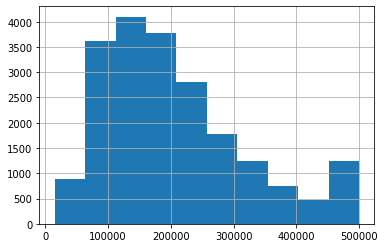

In [29]:
df["MedianHouseValue"].hist()

In [35]:
import numpy as np
#procesamiento variables numéricas MedianIncome MedianHouseValue
df['log_MedianIncome'] = np.log(df['MedianIncome'])
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
df = df.drop(columns=['MedianHouseValue', 'MedianIncome'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'MedianHouseAge':'log_MedianIncome'],
                                                    df['log_MedianHouseValue'],
                                                    test_size=.3,
                                                    random_state=2021)

In [37]:
from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor(random_state=2021).fit(X_train,y_train)

Por defecto *BaggingRegressor* generará 10 modelos. Podemos examinar cada uno de estos 10 modelos si lo deseamos:

In [38]:
for i in bagging_model.estimators_:
    print("Modelo: ",type(i), "Criterio: ",i.criterion, "Semilla: ",i.random_state)


Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  86662149
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  1868703353
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  1405477361
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  1013395746
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  1677377330
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  749423013
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  676891875
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  701642817
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  1162069113
Modelo:  <class 'sklearn.tree._classes.DecisionTreeRegressor'> Criterio:  mse Semilla:  1948912788


In [39]:
print("MSE:", mean_squared_error(y_test, bagging_model.predict(X_test)))
print("MAE:", median_absolute_error(y_test,bagging_model.predict(X_test)))
print("R2:", r2_score(y_test, bagging_model.predict(X_test)))

MSE: 0.059583733312501476
MAE: 0.11844441020363217
R2: 0.8206157642516708


Ahora podemos ver como el promedio de todos nuestros árboles mejoró un poco los indicadores vs lo que habiamos calculado con solo un modelo. Sin embargo, como el proceso de bagging usa los mismos atributos, existe una correlación entre los árboles, que podemos visualizarla de la siguiente manera:

In [41]:
from scipy import stats #para calcular correlación

store_rho = [] #aqui guardaremos las correlaciones que vamos calculando

bag_est = bagging_model.estimators_ #obtenemos los estimadores del modelo y
# recorremos dos veces los estimadores
for i in bag_est:
    for j in bag_est:
# y calculamos las correlaciones entre pares
        store_rho.append(stats.pearsonr(i.predict(X_test),j.predict(X_test))[0])
#como store_rho es una lista, podemos usar el comando respae para pasarlo de 1 dimension a 10x10    
store_rho = np.array(store_rho).reshape(len(bag_est), len(bag_est))

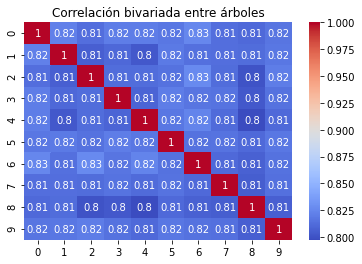

In [42]:
#podemos visualizar la correlación a través de un gráfico conocido como heatmap de seaborn
sns.heatmap(store_rho, cmap='coolwarm', annot=True)
plt.title("Correlación bivariada entre árboles");

Para eliminar la correlación generada por **Bagging** y unificar todo el conocimiento del día, pasaremos a un algoritmo que mezcla todo.

# Random Forest 

Lo que estabamos haciendo era seleccionar un conjunto de árboles y generábamos un muestreo de filas para añadir aleatoridad a los árboles. Sin embargo ahora se le agregará un nuevo nivel: se muestrearán ciertos atributos (columnas) para cada nuevo árbol. Así, por ejemplo, el primer árbol puede tener las primeras 3 columnas con las primeras 300 filas, y el segundo árbol puede tener las siguientes columnas, con el resto de filas, generando así independencia entre los modelos.

Lo anterior nos permitirá eliminar el sesgo creado por el bagging, pues ya no se está entrenando siempre con todos los atributos.

En python deberemos usar `RandomForestClassifier` o `RandomForestRegressor` segun sea el caso, ambos de la librería `sklearn.ensemble`.


Contras:
- Se pierde la interpretabilidad de un árbol de decisión aislado

Pros:
- Son mas dificiles de sobrajustar
- Permiten calcular **Feature Importance**

La implementación del modelo es igual que antes:

In [43]:
from sklearn.ensemble import RandomForestRegressor
RanForReg = RandomForestRegressor(random_state=0)
RanForReg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [44]:
print("MSE:", mean_squared_error(y_test, RanForReg.predict(X_test)))
print("MAE:", median_absolute_error(y_test,RanForReg.predict(X_test)))
print("R2:", r2_score(y_test, RanForReg.predict(X_test)))

MSE: 0.053334709051232554
MAE: 0.11119144674669545
R2: 0.8394292285809577


Podemos ver que su $R^2$ es mejor, y solucionamos el sesgo de correlación.

In [45]:
preds = pd.DataFrame

AttributeError: ignored

Como hemos podido ver, hay ciertos hiperparametros

# Ejercicios

Es sabido que, una entidad que presta servicios o productos (pudiera ser una empresa, un banco, una tienda, etcétera) puede mejorar la experiencia de cliente desarrollando productos personalizados en pos de las preferencias y necesidades de cada uno de sus clientes.


El set de datos _potencial_ contiene datos sobre clientes de una institución financiera:

- Customer ID: ID asociado al cliente
- Age: Edad en años del cliente
- Income: Ingreso anual del cliente
- Family: Tamaño del grupo familiar del cliente
- CCAvg: Cupo promedio mensual utilizado en tarjetas de crédito
- Education: Nivel educacional (1 si no es graduado, 2 graduado y 3 si posee estudios especializadoss (magister, doctorado, etcétera)
- Mortgage: Monto de la hipoteca (0 indica que no posee)
- ZIP Code: Código postal del domicilio


En la última campaña a cada cliente se le ofreció un producto personalizado en base a su comportamiento financiero, preferencias, capacidad de pago y necesidades. La variable target corresponde a Personal Loan el cual indica si el cliente tomó o no tomó este producto (¿El cliente aceptó o no el producto ofrecido? ), donde 0 indica que el cliente no adquirió el producto y 1 indica que sí lo adquirió.

Es de interés analizar cuáles pudieran ser los perfiles de clientes que tienen mayor probabilidad de aceptar el producto ofrecido, de manera de, identificar a los clientes con dichas características y priorizarlos a ellos en las próximas campañas.

- a) Cargue el set de datos utilizando la función read.excel de pandas. ¿Qué columnas le hacen sentido incluir en un modelo para predecir si un cliente tomará o no el producto ofrecido? Si desea eliminar alguna columna, recuerde que puede usar la función drop('nombre columna a eliminar', axis=1).




In [46]:
import pandas as pd
datos = pd.read_excel("/content/potencial.xlsx")

In [47]:
datos.head(10)

,ID,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan
0,1,25,49,91107,4,1.6,1,0,0
1,2,45,34,90089,3,1.5,1,0,0
2,3,39,11,94720,1,1.0,1,0,0
3,4,35,100,94112,1,2.7,2,0,0
4,5,35,45,91330,4,1.0,2,0,0
5,6,37,29,92121,4,0.4,2,155,0
6,7,53,72,91711,2,1.5,2,0,0
7,8,50,22,93943,1,0.3,3,0,0
8,9,35,81,90089,3,0.6,2,104,0
9,10,34,180,93023,1,8.9,3,0,1


In [49]:
datos.drop(["ID", "ZIP Code"], axis = 1)

,Age,Income,Family,CCAvg,Education,Mortgage,Personal Loan
0,25,49,4,1.6,1,0,0
1,45,34,3,1.5,1,0,0
2,39,11,1,1.0,1,0,0
3,35,100,1,2.7,2,0,0
4,35,45,4,1.0,2,0,0
...,...,...,...,...,...,...,...
4995,29,40,1,1.9,3,0,0
4996,30,15,4,0.4,1,85,0
4997,63,24,2,0.3,3,0,0
4998,65,49,3,0.5,2,0,0


- b) Determine cuáles son las variables predictoras que son categorías y obtenga las variables dummies correspondientes para incluirlas en el modelo. Recuerde que puede usar la función get_dummies() de pandas.


In [50]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             5000 non-null   int64  
 1   Age            5000 non-null   int64  
 2   Income         5000 non-null   int64  
 3   ZIP Code       5000 non-null   int64  
 4   Family         5000 non-null   int64  
 5   CCAvg          5000 non-null   float64
 6   Education      5000 non-null   int64  
 7   Mortgage       5000 non-null   int64  
 8   Personal Loan  5000 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 351.7 KB


In [51]:
datos["Education"] = datos["Education"].astype("category")
datos["Mortgage"] = datos["Mortgage"].astype("category") #bool

In [52]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ID             5000 non-null   int64   
 1   Age            5000 non-null   int64   
 2   Income         5000 non-null   int64   
 3   ZIP Code       5000 non-null   int64   
 4   Family         5000 non-null   int64   
 5   CCAvg          5000 non-null   float64 
 6   Education      5000 non-null   category
 7   Mortgage       5000 non-null   category
 8   Personal Loan  5000 non-null   int64   
dtypes: category(2), float64(1), int64(6)
memory usage: 301.0 KB


In [53]:
datos = pd.get_dummies(datos)

In [54]:
datos

,ID,Age,Income,ZIP Code,Family,CCAvg,Personal Loan,Education_1,Education_2,Education_3,Mortgage_0,Mortgage_75,Mortgage_76,Mortgage_77,Mortgage_78,Mortgage_79,Mortgage_80,Mortgage_81,Mortgage_82,Mortgage_83,Mortgage_84,Mortgage_85,Mortgage_86,Mortgage_87,Mortgage_88,Mortgage_89,Mortgage_90,Mortgage_91,Mortgage_92,Mortgage_93,Mortgage_94,Mortgage_95,Mortgage_96,Mortgage_97,Mortgage_98,Mortgage_99,Mortgage_100,Mortgage_101,Mortgage_102,Mortgage_103,...,Mortgage_449,Mortgage_452,Mortgage_455,Mortgage_458,Mortgage_461,Mortgage_464,Mortgage_466,Mortgage_467,Mortgage_470,Mortgage_475,Mortgage_477,Mortgage_481,Mortgage_483,Mortgage_485,Mortgage_496,Mortgage_500,Mortgage_505,Mortgage_508,Mortgage_509,Mortgage_522,Mortgage_524,Mortgage_535,Mortgage_541,Mortgage_547,Mortgage_550,Mortgage_553,Mortgage_565,Mortgage_567,Mortgage_569,Mortgage_571,Mortgage_577,Mortgage_581,Mortgage_582,Mortgage_587,Mortgage_589,Mortgage_590,Mortgage_601,Mortgage_612,Mortgage_617,Mortgage_635
0,1,25,49,91107,4,1.6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,45,34,90089,3,1.5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,39,11,94720,1,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,35,100,94112,1,2.7,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,35,45,91330,4,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,40,92697,1,1.9,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,4997,30,15,92037,4,0.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,4998,63,24,93023,2,0.3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,4999,65,49,90034,3,0.5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- c) Defina en un objeto X las variables predictoras y en Y la variable respuesta Personal Loan. Obtenga los set de entrenamiento y prueba en una proporción 5:1. Recuerde que la función train_test_split() es útil para realizar split simple, además fije una semilla 2021 (random_state=2021 en la función train_test_split()).


In [58]:
from sklearn.model_selection import train_test_split

X = datos.drop("Personal Loan", axis = 1)
y = datos["Personal Loan"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 2021)

- d) Obtenga un árbol de decisión con el set de datos de entrenamiento.  Obtenga el MSE del modelo en el set de prueba. Muestre el árbol obtenido, ¿qué observa?  ¿cuáles podrían ser los problemas de este árbol? ¿qué alternativas pudieran probarse para abordar este problema?


In [59]:
dec_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [60]:
print( "Test MSE:" , mean_squared_error(y_test,dec_tree.predict(X_test)).round( 5 ))
print( "Test MAE:" , median_absolute_error(y_test,dec_tree.predict(X_test)).round( 5 ))
print( "Test R2:" , r2_score(y_test, dec_tree.predict(X_test)).round( 5 ))

Test MSE: 0.016
Test MAE: 0.0
Test R2: 0.81733


- e) Plantee otro árbol de decisión pero definiendo como parámetro de control o _prepoda_ la profundidad máxima del árbol, para esto en la función DecisionTreeClassifier() añada como argumento max_depth=2 (profundidad máxima 2).  Obtenga el MSE en el set de prueba y compare con el modelo anterior. Observe el árbol obtenido. Comente. 


- f) Busque los mejores valores de los criterios de corte y máxima profundidad para este caso, con 10 validaciones cruzadas, y entregue sus valores (Hint: evalue los hiperparámetros criterion y max_depth)